# First look at the AirBnB dataset

Table of contents <a id='top'>

1. [Business Understanding](#business)
2. [What input data is available?](#input)
3. [Prices](#prices)
4. [Boolean Values](#booleans)
5. [Dates](#dates)
6. [Missing Data](#missing)
7. [Save the Data](#save)

In [168]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from jupyterthemes import jtplot
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

SEATTLE_CALENDAR = os.path.join(DATA_RAW, 'seattle', 'calendar.csv')
SEATTLE_LISTINGS = os.path.join(DATA_RAW, 'seattle', 'listings.csv')
SEATTLE_REVIEWS = os.path.join(DATA_RAW, 'seattle', 'reviews.csv')

import sys
sys.path.append(SRC_DIR)

In [169]:
calendar = pd.read_csv(SEATTLE_CALENDAR)
listings = pd.read_csv(SEATTLE_LISTINGS)
reviews = pd.read_csv(SEATTLE_REVIEWS)

**NOTE: I will refer to each property offered for rent as a "property", and to each of the characteristics of them as "features" (to disambiguate between the use of regular English and the use of "Data Science slang"). So "property" will always be a building, home, apartment, etc., in this analysis.**

## 1. Business Understanding: What is AirBnB? <a id='business'>
[Top](#top)

According to [Wikipedia](https://en.wikipedia.org/wiki/Airbnb)

> "AirBnB Inc. is a privately held global company headquartered in San Francisco that operates an online marketplace and hospitality service which is accessible via its websites and mobile apps. Members can use the service to arrange or offer lodging, primarily homestays, or tourism experiences. The company does not own any of the real estate listings, nor does it host events; as a broker, it receives commissions from every booking."

Resuming: they are intermediaries between people who want to rent a home, and people who want to offer their home for rent. They charge a commission for each booking. That fee is generally 3% of the rent price, but can be larger.

## 2. What input data is available? <a id='input'/>
[Top](#top)

In [170]:
print(calendar.shape)
calendar.head()

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [171]:
print(listings.shape)
listings.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [172]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [173]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [174]:
print(reviews.shape)
reviews.head()

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


There is a "listings" table which is static, and two "time series" tables: "calendar", which has about 1.4 millon rows, and "reviews" with about 85000.

In [175]:
calendar.date.describe()

count        1393570
unique           365
top       2016-05-06
freq            3818
Name: date, dtype: object

In [176]:
print(calendar.date.min())
print(calendar.date.max())

2016-01-04
2017-01-02


In [177]:
reviews.date.describe()

count          84849
unique          1930
top       2015-09-21
freq             580
Name: date, dtype: object

In [178]:
print(reviews.date.min())
print(reviews.date.max())

2009-06-07
2016-01-03


So, the time periods are not the same and they do not overlap. I assume the dataset was gathered at the begining of 2016, and that "calendar" represents the current reservations for the next year. That is confirmed by the "last_scrapped" column of the listings table.

## 3. Prices <a id='prices'></a>
[Top](#top)

It can be seen that the prices are recorded as strings, in $X format, at least in the calendar table. Let's transform them to floats.

In [179]:
from functools import update_wrapper

def decorator(d):
    """
    Make function d a decorator: d wraps a function fn.
    (Thanks to "Desing of Computer Programs" by Peter Norvig)
    """
    def _d(fn):
        return update_wrapper(d(fn), fn)
    update_wrapper(_d, d)
    return _d

@decorator
def pandify(scalar_fun):
    """ 
    The decorated function applies the scalar function to all values
    and accepts Series and DataFrames.
    Args:
        scalar_fun(function): a scalar function
    Returns:
        df_fun(function): a matrix/vector function for pandas DFs and Series
    """
    
    def df_fun(df):
        if isinstance(df, pd.Series):
            return df.apply(scalar_fun)
        elif isinstance(df, pd.DataFrame):
            return df.apply(lambda x: x.apply(scalar_fun))
        else:
            return None
        
    return df_fun

@pandify
def price_to_float(price_str):
    """ Converts a price like $67.0 to a float (67.0)"""
    if price_str is np.nan:
        return np.nan
    return float(price_str[1:].replace(',',''))

In [180]:
calendar.price = price_to_float(calendar.price)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [181]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 42.5+ MB


Also, the dates should be transformed, and the "available" column should be a boolean. That will be done later. Let's see the listings table, for prices now.

In [182]:
num_listings = listings.select_dtypes(include=['int', 'float'])
print(num_listings.shape)
num_listings.head()

(3818, 30)


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
0,241032,20160104002432,956883,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,...,95.0,10.0,10.0,10.0,10.0,9.0,10.0,NaN,2,4.07
1,953595,20160104002432,5177328,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,6,1.48
2,3308979,20160104002432,16708587,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,2,1.15
3,7421966,20160104002432,9851441,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,278830,20160104002432,1452570,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,...,92.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,1,0.89


Let's start a dictionary to classify the "listings" columns

In [183]:
listings_cols = dict()

In [184]:
num_cols = num_listings.columns.tolist()

# Save them to the general dictionary
listings_cols['num_cols'] = num_cols

In [185]:
obj_listings = listings.select_dtypes(include='object')
print(obj_listings.shape)
obj_listings.head(2)

(3818, 62)


,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",...,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t


Let's find any prices by searching for dollar signs

In [186]:
DOLLAR_SIGN = '\$'

def find_str(df, string=DOLLAR_SIGN):
    """
    Finds substrings in a dataframe.
    By default it searches for the dollar sign.
    """
    return df.apply(lambda x: x.str.contains(string), axis=1)

In [187]:
has_dsign = find_str(obj_listings)

# Those who have dollar signs in all their non-null entries
all_dsign = obj_listings[obj_listings.columns[has_dsign.all()]]
all_dsign.head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$85.00,NaN,NaN,NaN,NaN,$5.00
1,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00
3,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00
4,$450.00,NaN,NaN,$700.00,$125.00,$15.00


In [188]:
# And those who have any dollar sign in any row
any_dsign = obj_listings[obj_listings.columns[has_dsign.any()]]
any_dsign = any_dsign.drop(all_dsign.columns, axis=1)
any_dsign.head(2)

,name,summary,space,description,neighborhood_overview,notes,transit,host_about
0,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,"I am an artist, interior designer, and run a s..."
1,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Living east coast/left coast/overseas. Time i...


Those seem to have some random \$ signs, but they are probably not important. Let's check the fraction of those that have the \$ sign.

In [189]:
dsigns = find_str(any_dsign)
dsigns.mean()

name                     0.001048
summary                  0.010711
space                    0.032933
description              0.047669
neighborhood_overview    0.017947
notes                    0.078210
transit                  0.114078
host_about               0.001690
dtype: float64

Mostly irrelevant. Maybe "transit" has something interesting.

In [190]:
any_dsign.transit[dsigns.transit.fillna(False)].head(20)

8      Bus stop to downtown directly across the stree...
16     Taxi: Uber, Sidecar, and Lyft are all availabl...
34     Transportation:  If you aren't planning on ren...
40     Buses are right around the corner. An Uber X r...
45     FREE STREET PARKING ONLY. NO PERMIT OR PAYMENT...
55     Walkability Score: 99 out of 100 Daily errands...
75     Parking is available on the street and you can...
109    Bus 18 is just around the corner and takes you...
110    A bus stop from which you can be whisked swift...
133    King County Metro transit has stops within a c...
139    A major bus line, the 28, stops 1/2 block from...
163    We can arrange for an airport pickup for $50 (...
189    Metro bus 28 (2 blocks), which goes downtown a...
208    Uber is $10 from here to downtown, the bus is ...
213    Bus stops out the door, Uber is $10 to $15 to ...
217    Very close to public transit and you can get j...
234    ******Here is what you do if you prefer don't ...
262    The #13 bus stops on Bos

That is very reasonable: some of the "transit" texts state the price of transportation. Nothing else to do there. Let's transform the columns that are real prices.

In [191]:
price_cols = all_dsign.columns.tolist()
price_cols

['price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people']

In [192]:
# Save them to the general dictionary
listings_cols['price_cols'] = price_cols

In [193]:
listings[price_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$85.00,NaN,NaN,NaN,NaN,$5.00
1,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00
3,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00
4,$450.00,NaN,NaN,$700.00,$125.00,$15.00


In [194]:
listings[price_cols] = price_to_float(listings[price_cols])

In [195]:
listings[price_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,NaN,NaN,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,NaN,NaN,1000.0,300.0,25.0
3,100.0,650.0,2300.0,NaN,NaN,0.0
4,450.0,NaN,NaN,700.0,125.0,15.0


In [196]:
def transform_prices(calendar, listings, reviews):
    """ Transforms all the prices in '$x' format to float. """
    calendar.price = price_to_float(calendar.price)
    
    # Find features that have dollar signs in all non-null entries
    obj_listings = listings.select_dtypes(include='object')
    has_dsign = find_str(obj_listings)
    all_dsign = obj_listings[obj_listings.columns[has_dsign.all()]]
    price_cols = all_dsign.columns.tolist()
    
    listings[price_cols] = price_to_float(listings[price_cols])
    
    return calendar, listings, reviews

## 4. Boolean Values <a id='booleans'>
[Top](#top)

In [197]:
@pandify
def string2bool(text):
    """ Convert 'boolean strings' to booleans."""
    if (text == 't') or (text == 'True'):
        return True
    elif (text == 'f') or (text == 'False'):
        return False
    else:
        return np.nan

### Calendar

In [198]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [199]:
calendar.available = string2bool(calendar.available)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


### Listings

Let's find the columns that have 't' - 'f' values.

In [200]:
def is_tf(df):
    """ Which values are a 'boolean string'? """
    return (df == 't') | (df == 'f') | (df == 'True') | (df == 'False')

In [201]:
tf_any = is_tf(listings).sum() > 0
positive_tfs = is_tf(listings).mean()[tf_any]
positive_tfs

host_is_superhost                   0.999476
host_has_profile_pic                0.999476
host_identity_verified              0.999476
is_location_exact                   1.000000
has_availability                    1.000000
requires_license                    1.000000
instant_bookable                    1.000000
require_guest_profile_picture       1.000000
require_guest_phone_verification    1.000000
dtype: float64

There may be some missing data, but it is very clear that those columns are filled with 't's and 'f's

In [202]:
print(1 - listings[positive_tfs[:3].index].isnull().mean())
listings[positive_tfs[:3].index].isnull().sum()

host_is_superhost         0.999476
host_has_profile_pic      0.999476
host_identity_verified    0.999476
dtype: float64


host_is_superhost         2
host_has_profile_pic      2
host_identity_verified    2
dtype: int64

OK, two missing samples for each of those features.

In [203]:
tf_cols = positive_tfs.index.tolist()
listings[tf_cols] = string2bool(listings[tf_cols])
listings[tf_cols].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,has_availability,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,False,True,True,True,True,False,False,False,False
1,True,True,True,True,True,False,False,True,True
2,False,True,True,True,True,False,False,False,False
3,False,True,True,True,True,False,False,False,False
4,False,True,True,True,True,False,False,False,False


In [204]:
# Save the cols to the general dictionary
listings_cols['tf_cols'] = tf_cols

In [205]:
listings[tf_cols].iloc[0].apply(type)

host_is_superhost                          <class 'bool'>
host_has_profile_pic                       <class 'bool'>
host_identity_verified                     <class 'bool'>
is_location_exact                   <class 'numpy.bool_'>
has_availability                    <class 'numpy.bool_'>
requires_license                    <class 'numpy.bool_'>
instant_bookable                    <class 'numpy.bool_'>
require_guest_profile_picture       <class 'numpy.bool_'>
require_guest_phone_verification    <class 'numpy.bool_'>
Name: 0, dtype: object

In [206]:
listings[tf_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 9 columns):
host_is_superhost                   3816 non-null object
host_has_profile_pic                3816 non-null object
host_identity_verified              3816 non-null object
is_location_exact                   3818 non-null bool
has_availability                    3818 non-null bool
requires_license                    3818 non-null bool
instant_bookable                    3818 non-null bool
require_guest_profile_picture       3818 non-null bool
require_guest_phone_verification    3818 non-null bool
dtypes: bool(6), object(3)
memory usage: 111.9+ KB


In [207]:
def transform_booleans(calendar, listings, reviews):
    """ Transforms all the 'boolean string' values (t/f) to booleans. """
    # Calendar
    calendar.available = string2bool(calendar.available)
    
    # Listings
    tf_any = is_tf(listings).sum() > 0
    positive_tfs = is_tf(listings).mean()[tf_any]
    tf_cols = positive_tfs.index.tolist()
    listings[tf_cols] = string2bool(listings[tf_cols])

    return calendar, listings, reviews

## 5. Dates <a id='dates'>
[Top](#top)

In [208]:
from datetime import datetime

@pandify
def string2date(text):
    """ Convert 'date strings' to dates. """
    if text is np.nan:
        return np.nan
    return datetime.strptime(text, '%Y-%m-%d')

### Calendar

In [209]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [210]:
calendar.date.dtype

dtype('O')

In [211]:
calendar.date = string2date(calendar.date)
print(calendar.date.dtype)

datetime64[ns]


In [212]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


### Listings

Let's try to find "date" columns. To do that, let's classify the columns by visual inspection.

#### Visual classification of listings columns.

In [213]:
unknown_listings = listings.drop(
    tf_cols, axis=1).select_dtypes(exclude=['int', 'float'])
print(unknown_listings.shape)
unknown_listings.iloc[:2].T

(3818, 47)


,0,1
listing_url,https://www.airbnb.com/rooms/241032,https://www.airbnb.com/rooms/953595
last_scraped,2016-01-04,2016-01-04
name,Stylish Queen Anne Apartment,Bright & Airy Queen Anne Apartment
summary,NaN,Chemically sensitive? We've removed the irrita...
space,Make your self at home in this charming one-be...,"Beautiful, hypoallergenic apartment in an extr..."
description,Make your self at home in this charming one-be...,Chemically sensitive? We've removed the irrita...
experiences_offered,none,none
neighborhood_overview,NaN,"Queen Anne is a wonderful, truly functional vi..."
notes,NaN,What's up with the free pillows? Our home was...
transit,NaN,"Convenient bus stops are just down the block, ..."


Let's remove the "free text" columns.

In [214]:
free_text_cols = [
    'name',
    'summary',
    'space',
    'description',
    'neighborhood_overview',
    'notes',
    'transit',
    'host_about',
    'host_name'
]

# Save them to the general dictionary
listings_cols['free_text_cols'] = free_text_cols

In [215]:
url_cols = [
    'listing_url',
    'picture_url',
    'host_url',
    'host_thumbnail_url',
    'host_picture_url',
    'thumbnail_url',
    'medium_url',
    'xl_picture_url'
]

# Save them to the general dictionary
listings_cols['url_cols'] = url_cols

In [216]:
location_cols = [
    'street',  # Seems to contain values from other features
    'host_location',
    'host_neighbourhood',
    'neighbourhood',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'city',
    'state',
    'zipcode',  # Better treated as categorical than as integers, I think
    'market',
    'smart_location',
    'country_code',
    'country'
]

# Save them to the general dictionary
listings_cols['location_cols'] = location_cols

In [217]:
unknown_listings = unknown_listings.drop(free_text_cols, axis=1)
unknown_listings = unknown_listings.drop(url_cols, axis=1)
unknown_listings = unknown_listings.drop(location_cols, axis=1)
print(unknown_listings.shape)
unknown_listings.iloc[:2].T

(3818, 17)


,0,1
last_scraped,2016-01-04,2016-01-04
experiences_offered,none,none
host_since,2011-08-11,2013-02-21
host_response_time,within a few hours,within an hour
host_response_rate,96%,98%
host_acceptance_rate,100%,100%
host_verifications,"['email', 'phone', 'reviews', 'kba']","['email', 'phone', 'facebook', 'linkedin', 're..."
property_type,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt
bed_type,Real Bed,Real Bed


The "date" columns are evident now. There are also some percentage columns that could be transformed to float, and some lists and dictionaries that could be expanded.

In [230]:
is_date = listings.iloc[0].str.contains('\d{4}-\d{2}-\d{2}').fillna(False)
date_listings = listings.loc[:, is_date]
date_listings.head()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
0,2016-01-04,2011-08-11,2016-01-04,2011-11-01,2016-01-02
1,2016-01-04,2013-02-21,2016-01-04,2013-08-19,2015-12-29
2,2016-01-04,2014-06-12,2016-01-04,2014-07-30,2015-09-03
3,2016-01-04,2013-11-06,2016-01-04,NaN,NaN
4,2016-01-04,2011-11-29,2016-01-04,2012-07-10,2015-10-24


In [232]:
date_cols = listings.columns[is_date].tolist()
date_cols

['last_scraped',
 'host_since',
 'calendar_last_scraped',
 'first_review',
 'last_review']

In [51]:
# Save them to the general dictionary
listings_cols['date_cols'] = date_cols

Just as a reminder for further transformations, let's look at the unclassified columns.

In [52]:
unknown_listings = unknown_listings.drop(date_cols, axis=1)
print(unknown_listings.shape)
unknown_listings.iloc[:2].T

(3818, 12)


,0,1
experiences_offered,none,none
host_response_time,within a few hours,within an hour
host_response_rate,96%,98%
host_acceptance_rate,100%,100%
host_verifications,"['email', 'phone', 'reviews', 'kba']","['email', 'phone', 'facebook', 'linkedin', 're..."
property_type,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt
bed_type,Real Bed,Real Bed
amenities,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
calendar_updated,4 weeks ago,today


In [53]:
percent_cols = unknown_listings.columns[
    unknown_listings.columns.str.contains('rate')].tolist()
percent_cols

['host_response_rate', 'host_acceptance_rate']

In [54]:
# Save them to the general dictionary
listings_cols['percent_cols'] = percent_cols

In [55]:
list_cols = ['host_verifications']
dict_cols = ['amenities']
time_cols = ['host_response_time', 'calendar_updated']

In [56]:
# Save them to the general dictionary
listings_cols['list_cols'] = list_cols
listings_cols['dict_cols'] = dict_cols
listings_cols['time_cols'] = time_cols

In [57]:
unknown_listings = unknown_listings.drop(percent_cols, axis=1)
unknown_listings = unknown_listings.drop(list_cols, axis=1)
unknown_listings = unknown_listings.drop(dict_cols, axis=1)
unknown_listings = unknown_listings.drop(time_cols, axis=1)
print(unknown_listings.shape)
unknown_listings.iloc[:2].T

(3818, 6)


,0,1
experiences_offered,none,none
property_type,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt
bed_type,Real Bed,Real Bed
jurisdiction_names,WASHINGTON,WASHINGTON
cancellation_policy,moderate,strict


In [58]:
categorical_simple_cols = unknown_listings.columns.tolist()
categorical_simple_cols

['experiences_offered',
 'property_type',
 'room_type',
 'bed_type',
 'jurisdiction_names',
 'cancellation_policy']

In [59]:
# Save them to the general dictionary
listings_cols['categorical_simple_cols'] = categorical_simple_cols

#### Filling the date columns

In [60]:
listings[date_cols].head()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
0,2016-01-04,2011-08-11,2016-01-04,2011-11-01,2016-01-02
1,2016-01-04,2013-02-21,2016-01-04,2013-08-19,2015-12-29
2,2016-01-04,2014-06-12,2016-01-04,2014-07-30,2015-09-03
3,2016-01-04,2013-11-06,2016-01-04,NaN,NaN
4,2016-01-04,2011-11-29,2016-01-04,2012-07-10,2015-10-24


In [61]:
listings[date_cols].isnull().sum()

last_scraped               0
host_since                 2
calendar_last_scraped      0
first_review             627
last_review              627
dtype: int64

In [62]:
listings[date_cols] = string2date(listings[date_cols])

In [63]:
listings[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 5 columns):
last_scraped             3818 non-null datetime64[ns]
host_since               3816 non-null datetime64[ns]
calendar_last_scraped    3818 non-null datetime64[ns]
first_review             3191 non-null datetime64[ns]
last_review              3191 non-null datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 149.2 KB


In [64]:
listings[date_cols].isnull().sum()

last_scraped               0
host_since                 2
calendar_last_scraped      0
first_review             627
last_review              627
dtype: int64

In [65]:
listings[date_cols].head()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
0,2016-01-04,2011-08-11,2016-01-04,2011-11-01,2016-01-02
1,2016-01-04,2013-02-21,2016-01-04,2013-08-19,2015-12-29
2,2016-01-04,2014-06-12,2016-01-04,2014-07-30,2015-09-03
3,2016-01-04,2013-11-06,2016-01-04,NaT,NaT
4,2016-01-04,2011-11-29,2016-01-04,2012-07-10,2015-10-24


Maybe the host_since feature can be filled, if the host appears in another row. The first_review and last_review, are reasonably null (not all properties have reviews).

### Reviews

In [66]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [67]:
reviews.date.isnull().sum()

0

In [68]:
reviews.date = string2date(reviews.date)
print(reviews.date.dtype)
reviews.head()

datetime64[ns]


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [233]:
def transform_dates(calendar, listings, reviews):
    """ Transforms all the 'date strings' to date format. """
    # Calendar
    calendar.date = string2date(calendar.date)
    
    #Listings
    is_date = listings.iloc[0].str.contains('\d{4}-\d{2}-\d{2}').fillna(False)
    date_cols = listings.columns[is_date].tolist()
    listings[date_cols] = string2date(listings[date_cols])
    
    # Reviews
    reviews.date = string2date(reviews.date)
    
    return calendar, listings, reviews

## 6. Missing data <a id='missing'>
[Top](#top)

### Calendar

In [69]:
calendar.isnull().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

So, 33% of the prices are missing. Do those missing prices coincide with the t or f label?

In [70]:
calendar.available[calendar.price.isnull()].value_counts()

False    459028
Name: available, dtype: int64

Indeed, all the missing prices are for properties that are not available. That could mean that they are not currently being offered in the site.

What about the other way round? Do all the properties with "f" have a missing price?

In [71]:
calendar.price[calendar.available==False].value_counts(dropna=False)

NaN    459028
Name: price, dtype: int64

Yes! Indeed the NaN IS the default value for a property that is not available!

Let's fill the missing prices using the closest price in time, or the listings table price, if no one is available in calendar. Before that, are there any properties that are never available?

In [72]:
not_available = calendar.groupby('listing_id')['available'].apply(
    lambda x: (x==False).all()).sort_values(ascending=False)
not_a_ids = not_available[not_available].index.tolist()
len(not_a_ids)

95

Then 95 properties are never available in the period. Those will be filled with their "listings" price.

In [73]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [74]:
def fill_in_time(ts):
    """ Fills a time series by forward filling and then backfilling"""
    return ts.fillna(method='ffill').fillna(method='bfill')

In [75]:
def get_ts(df, values_col='price'):
    """
    Extracts one time series per listing.
    Args:
        df(pd.DataFrame): a dataframe with listing_id, date, and a value that 
        changes in time (price, as default).
        values_col(str): the column to take as dependent variable.
    Returns:
        pd.DataFrame: A time series, indexed in dates, has one column per 
        listing.
    """
    return pd.pivot_table(data=df,
                          index='date', 
                          columns='listing_id', 
                          values=values_col)

In [76]:
# Create a time series and then fill the missing data in time
prices_ts = get_ts(calendar)
prices_ts = prices_ts.apply(fill_in_time)
print(prices_ts.shape)
prices_ts.head()

(365, 3723)


listing_id,3335,4291,5682,6606,7369,9419,9460,9531,9534,9596,...,10299195,10309898,10310373,10318171,10319529,10331249,10332096,10334184,10339145,10340165
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,26.0,250.0,20.0,50.0,49.0,45.0,40.0,120.0,219.0,43.0
2016-01-05,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,26.0,250.0,20.0,50.0,49.0,45.0,40.0,120.0,219.0,43.0
2016-01-06,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,26.0,250.0,20.0,50.0,49.0,45.0,40.0,120.0,219.0,43.0
2016-01-07,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,26.0,250.0,20.0,50.0,49.0,45.0,40.0,120.0,219.0,43.0
2016-01-08,120.0,82.0,50.0,100.0,85.0,70.0,109.0,165.0,125.0,125.0,...,26.0,250.0,20.0,50.0,49.0,45.0,40.0,120.0,219.0,43.0


Are all the listings included there?

In [77]:
num_listings = calendar.listing_id.unique().shape[0]
num_listings

3818

So, we lost some listings that probably had no values. How many?

In [78]:
num_listings - prices_ts.shape[1]

95

Good! That confirms that the lost listings are those that had only missing data.

Just out of curiosity: do all the dates have an entry for every listing_id?

In [79]:
num_listings = calendar.groupby('date').listing_id.count()
num_listings.describe()

count     365.0
mean     3818.0
std         0.0
min      3818.0
25%      3818.0
50%      3818.0
75%      3818.0
max      3818.0
Name: listing_id, dtype: float64

Indeed. That means that, aside from the "all missing prices" listings, the time series has exactly the same number of entries as the price series.

In [80]:
prices_ts.size == (calendar.price.shape[0] - calendar.date.unique().shape[0] * 95)

True

Great!
Let's recombine the time series to the calendar dataframe, and then fill the prices of the listings that have all prices "missing".

In [81]:
def fill_df_in_time(df, idx_col='listing_id', value_col='price'):
    """
    Takes a dataframe with an 'id' column and a 'date' column and fills the 
    value_col missing data as many time series, grouped by 'id' (forwardfills 
    and then backfills).
    """
    tmp_df = df.copy()
    ts = get_ts(tmp_df, values_col=value_col)
    ts = ts.apply(fill_in_time)
    tmp_df = tmp_df.set_index([idx_col, 'date'])
    tmp_df.price = tmp_df.price.fillna(ts.unstack())
    return tmp_df.reset_index()

Let's test the function a bit...

In [82]:
new_cal = fill_df_in_time(calendar)
(new_cal[~calendar.price.isnull()] == calendar[~calendar.price.isnull()]).mean()

listing_id    1.0
date          1.0
available     1.0
price         1.0
dtype: float64

OK. That didn't change the calendar values that already were not missing.

In [83]:
print(calendar.isnull().mean())
print(new_cal.isnull().mean())

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64
listing_id    0.000000
date          0.000000
available     0.000000
price         0.024882
dtype: float64


The missing data was reduced from 33% to 2.5%.

Now let's fill the "all missing" listings.

In [84]:
def fill_with_listings(calendar, listings):
    """ Fill the prices with the listings prices. """
    
    listings_price = listings[['id', 'price']].rename(columns={
        'id':'listing_id'}).set_index('listing_id').price

    new_cal = calendar.copy()
    new_cal = new_cal.set_index('listing_id')
    new_cal.price = new_cal.price.fillna(listings_price)
    
    return new_cal.reset_index()

Let's test fill_with_listings

In [85]:
final = fill_with_listings(new_cal, listings)

In [86]:
final.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,85.0
3,241032,2016-01-07,False,85.0
4,241032,2016-01-08,False,85.0


In [87]:
final.isnull().mean()

listing_id    0.0
date          0.0
available     0.0
price         0.0
dtype: float64

In [88]:
(final[~new_cal.price.isnull()] == new_cal[~new_cal.price.isnull()]).mean()

listing_id    1.0
date          1.0
available     1.0
price         1.0
dtype: float64

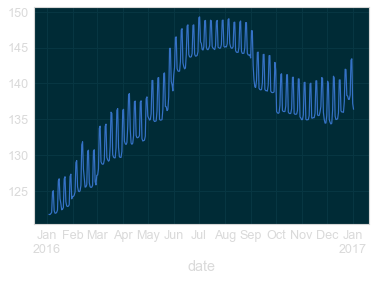

In [89]:
get_ts(final).mean(axis=1).plot()

Nice. There is a clear weekly seasonality (probably weekends are more expensive), and also there seems to be some yearly seasonality. I will study that further in later notebooks.

Let's group all that in one function.

In [90]:
def fill_calendar_na(calendar, listings):
    """ A specific function to fill the calendar missing values."""
    new_cal = calendar.copy()
    new_cal = fill_df_in_time(new_cal)
    return fill_with_listings(new_cal, listings)

In [91]:
calendar = fill_calendar_na(calendar, listings)

In [92]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,85.0
3,241032,2016-01-07,False,85.0
4,241032,2016-01-08,False,85.0


In [93]:
calendar.isnull().mean()

listing_id    0.0
date          0.0
available     0.0
price         0.0
dtype: float64

### Reviews

In [94]:
reviews.isnull().mean()

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64

There are some very few comments missing. About 0.02%. Doesn't look relevant.

In [95]:
reviews[reviews.comments.isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


Those are too few rows, and they don't give any useful information, so I will drop them, as they seem to be error (possibly internet connection failures or others).

In [96]:
reviews = reviews.dropna()
reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [97]:
def fill_reviews_na(reviews):
    return reviews.dropna()

### Listings

In [98]:
listings.isnull().mean().sort_values(ascending=False)

license                             1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
reviews_per_month                   0.164222
first_review                        0.164222
last_review                         0.164222
space                               0.149031
host_respo

There are some columns with a lot of missing data in "listings". In particular the "license" column, probably should be removed.
On the other hand, the "price" column has no missing data. Those values could be used to fill the calendar table, but they may not be updated. I assume the "price" in listings is the last one known, while the calendar table has the full price history.

In [99]:
has_missing_feats = listings.columns[listings.isnull().sum() > 0].tolist()
print('There are {} columns in total.'.format(listings.shape[1]))
print('Of those, {} are missing.'.format(len(has_missing_feats)))

There are 92 columns in total.
Of those, 45 are missing.


Let's retreive the classification of listings columns that was made before.

In [100]:
from itertools import chain

known_cols = list(chain(*listings_cols.values()))
len(known_cols)

92

In [101]:
listings.shape

(3818, 92)

In [102]:
listings.columns.isin(known_cols).sum() / listings.shape[1]

1.0

Ok. All the columns are classified

In [103]:
list(listings_cols.keys())

['num_cols',
 'price_cols',
 'tf_cols',
 'free_text_cols',
 'url_cols',
 'location_cols',
 'date_cols',
 'percent_cols',
 'list_cols',
 'dict_cols',
 'time_cols',
 'categorical_simple_cols']

Let's refactor that into a dataframe

In [104]:
listings_cols_df = pd.DataFrame(index=known_cols, columns=['kind'])
for key, val in listings_cols.items():
    for col in val:
        listings_cols_df.loc[col, 'kind'] = key
listings_cols_df

,kind
id,num_cols
scrape_id,num_cols
host_id,num_cols
host_listings_count,num_cols
host_total_listings_count,num_cols
latitude,num_cols
longitude,num_cols
accommodates,num_cols
bathrooms,num_cols
bedrooms,num_cols


#### num_cols

In [105]:
num_listings = listings[num_cols]
num_listings.isnull().mean().sort_values(ascending=False)

license                           1.000000
square_feet                       0.974594
review_scores_checkin             0.172342
review_scores_accuracy            0.172342
review_scores_value               0.171818
review_scores_location            0.171556
review_scores_cleanliness         0.171032
review_scores_communication       0.170508
review_scores_rating              0.169460
reviews_per_month                 0.164222
bathrooms                         0.004191
bedrooms                          0.001572
host_listings_count               0.000524
host_total_listings_count         0.000524
beds                              0.000262
longitude                         0.000000
accommodates                      0.000000
latitude                          0.000000
host_id                           0.000000
scrape_id                         0.000000
maximum_nights                    0.000000
guests_included                   0.000000
minimum_nights                    0.000000
calculated_

In [106]:
(~listings.license.isnull()).sum()

0

The license attribute has no values. Let's drop it.

In [107]:
has_missing = num_listings.columns[num_listings.isnull().sum() > 0].tolist()
len(has_missing)

15

In [108]:
listings[has_missing].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
host_listings_count            3816 non-null float64
host_total_listings_count      3816 non-null float64
bathrooms                      3802 non-null float64
bedrooms                       3812 non-null float64
beds                           3817 non-null float64
square_feet                    97 non-null float64
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
license                        0 non-null float64
reviews_per_month              3191 non-null float64
dtypes: float64(15)
memory usage: 447.5 KB


They're all floats, but some of them shouldn't, I think.

In [109]:
np.sort(listings.bedrooms.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., nan])

Better as an int

In [110]:
np.sort(listings.bathrooms.unique())

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 8. , nan])

It is a float, but 2*bathrooms would be an int.

In [111]:
np.sort(listings.beds.unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 15., nan])

Typical int

In [112]:
np.sort(listings.reviews_per_month.unique())[:5]

array([0.02, 0.03, 0.04, 0.05, 0.06])

That's a real float!

In [113]:
np.sort(listings.host_listings_count.unique())

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  15.,  17.,  18.,  19.,  21.,  34.,  36.,  37.,  48.,
        84., 163., 169., 354., 502.,  nan])

Clearly an integer

In [114]:
np.sort(listings.host_total_listings_count.unique())

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  15.,  17.,  18.,  19.,  21.,  34.,  36.,  37.,  48.,
        84., 163., 169., 354., 502.,  nan])

Another int

In [115]:
np.sort(listings.square_feet.unique())

array([0.00e+00, 1.00e+00, 2.00e+00, 3.00e+00, 1.20e+02, 1.40e+02,
       1.70e+02, 1.83e+02, 2.00e+02, 2.50e+02, 3.00e+02, 3.40e+02,
       3.50e+02, 4.00e+02, 4.20e+02, 4.35e+02, 4.50e+02, 4.85e+02,
       5.00e+02, 5.50e+02, 6.00e+02, 6.50e+02, 6.60e+02, 6.75e+02,
       7.00e+02, 7.10e+02, 7.30e+02, 7.50e+02, 7.70e+02, 8.00e+02,
       8.50e+02, 9.00e+02, 9.50e+02, 1.00e+03, 1.10e+03, 1.15e+03,
       1.20e+03, 1.30e+03, 1.40e+03, 1.60e+03, 1.80e+03, 1.85e+03,
       2.00e+03, 2.10e+03, 2.60e+03, 2.75e+03, 3.00e+03,      nan])

That one has only integer values, but it's ok as a float. No need to convert. Anyway, more than 97% of the properties don't have that value. I will drop it.


Let's fill the bathrooms and the ints with the most frequent values.

The floats shall be filled with the mean.

Before filling, let's create features that track missing features.

In [116]:
drop = [
    'license',
    'square_feet'
]

most_frequent = [
    'bathrooms',
    'bedrooms',
    'beds',
    'host_listings_count',
    'host_total_listings_count'
]

# Others: mean
mean = list(set(listings[has_missing].columns) - set(drop) - set(most_frequent))

In [234]:
def create_is_missing(df, cols):
    """
    Creates a new feature with 1 in the places where the 'cols' have missing 
    values.
    """
    missing_df = df[cols].isnull().astype(int).rename(columns={
        c: c + '_missing' for c in cols})
    return df.join(missing_df)

Let's create "is_missing" features, but only for those features that have more than 10% missing data (and less than 90%; those with more than 90% missing data will be dropped).

In [237]:
feat_cols = num_listings.columns[(num_listings.isnull().mean() > 0.1) &
                                 (num_listings.isnull().mean() < 0.9)].tolist()
feat_cols

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [143]:
# Create the "is_missing" feature
listings = create_is_missing(listings, feat_cols)

In [144]:
# Drop the features that have too little data
listings = listings.drop(drop, axis=1)
for d in drop:
    num_cols.remove(d)
listing_cols_df = listings_cols_df.drop(drop)

In [145]:
# Fill with the most frequent or the mean
listings[most_frequent] = listings[most_frequent].fillna(
    listings[most_frequent].median())

listings[mean] = listings[mean].fillna(
    listings[mean].mean())

In [146]:
# Check the results
listings[num_cols].isnull().mean().sort_values(ascending=False)

reviews_per_month                 0.0
calculated_host_listings_count    0.0
scrape_id                         0.0
host_id                           0.0
host_listings_count               0.0
host_total_listings_count         0.0
latitude                          0.0
longitude                         0.0
accommodates                      0.0
bathrooms                         0.0
bedrooms                          0.0
beds                              0.0
guests_included                   0.0
minimum_nights                    0.0
maximum_nights                    0.0
availability_30                   0.0
availability_60                   0.0
availability_90                   0.0
availability_365                  0.0
number_of_reviews                 0.0
review_scores_rating              0.0
review_scores_accuracy            0.0
review_scores_cleanliness         0.0
review_scores_checkin             0.0
review_scores_communication       0.0
review_scores_location            0.0
review_score

In [164]:
def get_column_by_kind(listing_cols_df, kind):
    return listing_cols_df.index[
        listing_cols_df.kind == kind].tolist()

In [159]:
def fill_num_cols(listings, num_cols):
    """
    Fills the missing data in the numeric features of the listings dataframe.
    """
    num_cols = get_column_by_kind(listings_cols_df, 'num_cols')
    num_listings = listings[num_cols]
    has_missing = num_listings.columns[
        num_listings.isnull().sum() > 0].tolist()
    drop = [
        'license',
        'square_feet'
    ]
    most_frequent = [
        'bathrooms',
        'bedrooms',
        'beds',
        'host_listings_count',
        'host_total_listings_count'
    ]
    # Others, mean
    mean = list(
        set(listings[has_missing].columns) - set(drop) - set(most_frequent))
    
    # Create the "is_missing" feature for features with medium missing data
    feat_cols = num_listings.columns[(num_listings.isnull().mean() > 0.1) &
                                 (num_listings.isnull().mean() < 0.9)].tolist()
    listings = create_is_missing(listings, feat_cols)
    
    # Drop the features that have too little data
    listings = listings.drop(drop, axis=1)
    listing_cols_df = listings_cols_df.drop(drop)
    
    # Fill with the most frequent or the mean
    listings[most_frequent] = listings[most_frequent].fillna(
    listings[most_frequent].median())
    listings[mean] = listings[mean].fillna(
    listings[mean].mean())
    
    return listings, listing_cols_df

#### price_cols

In [238]:
price_cols = get_column_by_kind(listing_cols_df, 'price_cols')
price_cols

['price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people']

In [240]:
listings[price_cols].isnull().mean().sort_values(ascending=False)

monthly_price       0.602672
security_deposit    0.511262
weekly_price        0.473808
cleaning_fee        0.269775
extra_people        0.000000
price               0.000000
dtype: float64

I think weekly_price and monthly price can be estimated from the daily price, but I would keep a feature marking when they where originally missing. The others can be filled with the mean, but I would also keep the "is_missing" feature, because there is a relevant amount of missing data.

In [245]:
week_factor = (listings.weekly_price / listings.price).mean()
week_factor

6.5135903328221945

In [246]:
month_factor = (listings.monthly_price / listings.price).mean()
month_factor

22.200647226406094

In [247]:
# Fill the long-term prices with the daily price
listings.weekly_price = listings.weekly_price.fillna(
    listings.price * week_factor)
listings.monthly_price = listings.monthly_price.fillna(
    listings.price * month_factor)

In [258]:
listings[price_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,553.655178,1887.055014,NaN,NaN,5.0
1,150.0,1000.000000,3000.000000,100.0,40.0,0.0
2,975.0,6350.750575,21645.631046,1000.0,300.0,25.0
3,100.0,650.000000,2300.000000,NaN,NaN,0.0
4,450.0,2931.115650,9990.291252,700.0,125.0,15.0


In [373]:
def prop_vs_mean(x, y):
    """ Proportional dependency vs "taking the mean" comparison. """
    data = pd.concat([x, y], axis=1).dropna(how='any')
    x = data[x.name]
    y = data[y.name]
    
    a = (y.values / x.values).mean()
    plt.scatter(x, y, label='Data')
    plt.hlines(y.mean(), x.min(), x.max(), colors='r', label='Mean')
    x_t = np.linspace(x.min(), x.max(), 1000)
    plt.plot(x_t, a * x_t, 'g', label='Proportional')
    plt.legend()

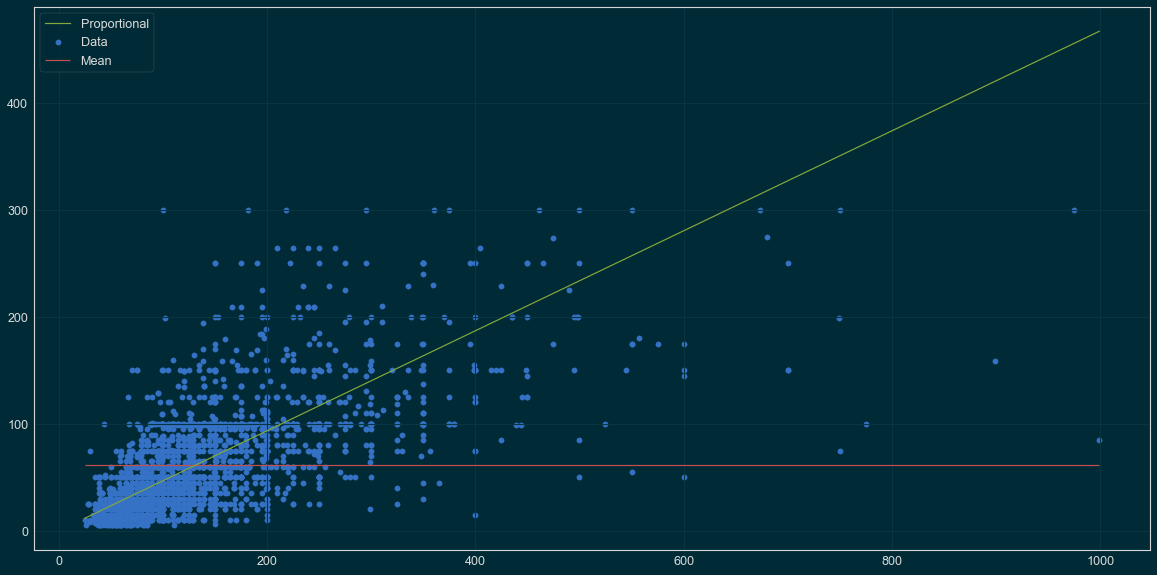

In [374]:
prop_vs_mean(listings.price, listings.cleaning_fee)

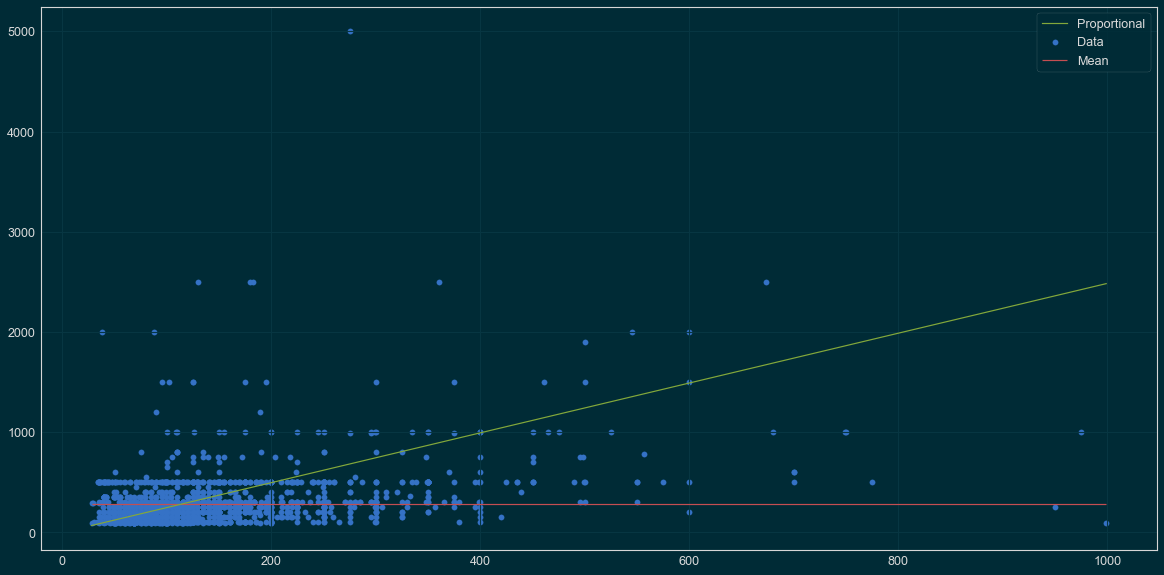

In [375]:
prop_vs_mean(listings.price, listings.security_deposit)

Let's use a proportional model for the cleaning fee, but fill with the mean the security deposit

In [377]:
# Fill the cleaning fee proportionally to the price
cleaning_coef = (listings.cleaning_fee / listings.price).mean()
listings.cleaning_fee = listings.cleaning_fee.fillna(cleaning_coef * listings.price)
# Fill the security deposit with the mean
listings.security_deposit = listings.security_deposit.fillna(
    listings.security_deposit.mean())

In [379]:
listings[price_cols].isnull().sum().sum()

0

In [383]:
def fill_price_cols(listings, listing_cols_df):
    """ Fill the missing data for the 'price' columns. """
    
    # Fill the long-term prices with the daily price
    week_factor = (listings.weekly_price / listings.price).mean()
    listings.weekly_price = listings.weekly_price.fillna(
        listings.price * week_factor)

    month_factor = (listings.monthly_price / listings.price).mean()
    listings.monthly_price = listings.monthly_price.fillna(
        listings.price * month_factor)
    
    # Fill the cleaning fee proportionally to the price
    cleaning_coef = (listings.cleaning_fee / listings.price).mean()
    listings.cleaning_fee = listings.cleaning_fee.fillna(cleaning_coef * listings.price)
    
    # Fill the security deposit with the mean
    listings.security_deposit = listings.security_deposit.fillna(
        listings.security_deposit.mean())
    
    return listings, listing_cols_df

## Save the data <a id='save'>
[Top](#top)

In [163]:
listings_cols_df.to_pickle(os.path.join(DATA_INTERIM, 'seattle', 'listings_cols_df.pkl'))